## Intro

This is an example notebook of using U-Net in segmenting brain tumors from MRI images. U-net is a deep neural network consisting of an encoder and decoder sides, that are connected to each other. U-nets have been found to be accurate and useful in segmentation tasks due to their structure. Segmentation tasks include giving the model a full color image (or other image data) and it gives out as a result one or more parts of the image recognized as a separate area. 

**Purpose:** showcase skills and knowledge in Tensorflow and medical field by utilizing machine learning algorithm in segmenting images.

**Inputs:**  
About 3000 image-pairs of MRI brain scans. All of the patients have some kind of tumor. The full image is accompanied by a mask, which shows as value of 1 the tumor areas. The data is from https://figshare.com/articles/dataset/brain_tumor_dataset/1512427 and is in size of 512 x 512 rbg-images. The dataset was chosen since it's quite small in size, but still representing a real-life scenario and usable for U-net.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.io import imread, imsave
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Concatenate, BatchNormalization, Dropout
from keras.models import Model
from keras.initializers import HeUniform
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam 
from tqdm.keras import TqdmCallback

Let's plot some of the images to study the data we have.

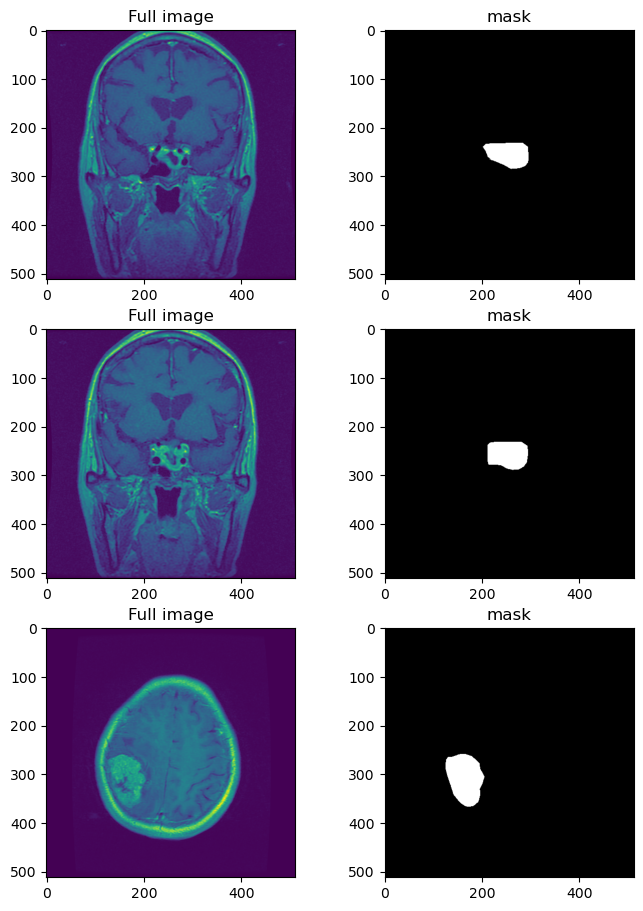

In [2]:
PATH_image = "data/07 - Medical Image Segmentation Brain/images/brain"
PATH_mask = "data/07 - Medical Image Segmentation Brain/mask/mask"

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,11))
for i in range(3):
    img_full = imread(os.path.join(PATH_image,os.listdir(PATH_image)[i+99]))
    img_mask = imread(os.path.join(PATH_mask,os.listdir(PATH_mask)[i+99]))
    ax[i][0].imshow(img_full)
    ax[i][1].imshow(img_mask,cmap="gray")
    ax[i][0].set_title("Full image")
    ax[i][1].set_title("mask")

In [3]:
# All patinets should have tumor according to the dataset info, but just in case there are 
# some cases without tumors (completely empty/black masks) we can iterate through them and
# could all the masks that are complete empty

has_tumor = []
for img in tqdm(os.listdir(PATH_mask)):
    img_mask = imread(os.path.join(PATH_mask,img),as_gray=True)
    tumor = 1 if sum(img_mask.ravel())>0 else 0
    has_tumor.append(tumor)

100%|██████████████████████████████████████████████████████████████████████████████| 3064/3064 [01:41<00:00, 30.08it/s]


0  
Yes    3064
Name: count, dtype: int64


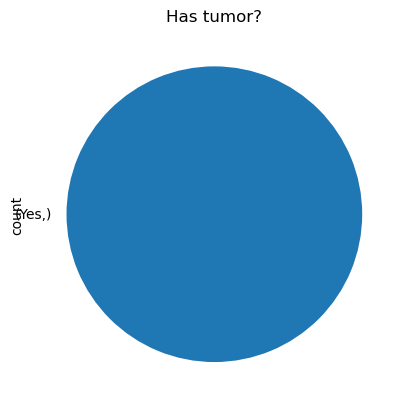

In [4]:
counts = pd.DataFrame(has_tumor).replace({0:"No",1:"Yes"}).value_counts()
counts.plot(kind="pie",title="Has tumor?")
print(counts)

All masks do have a tumor of some size marked.

Let's prepare the data with Tensorflow's ImageDataGenerator. 

Typically in computer vision tasks we would do image manipulation, for example rotate, shift or shear the images to create new kinds of artificial data. However, in this case we only randomly flip the images horizontally, but don't do any other manipulation since normally MRI images are always from the same angle and not sheared or rotated (also manipulation with ImageDataGenerator increases the training time by 2-3x if we include any additional manipulation for some reason).

For Tensorflow to recognize images and their corresponding masks, the folder structure has to be the following
- folder/images/images
- folder/mask/mask

where the first folder has the full images and the second folder the masks.

In [5]:
seed = 42
image_size = 256 # Scale down images for faster training, in real situations we would want to use full size of input data
batch_size = 32
val_split = 0.2 # Use 20% of the data as validation

PATH_images = "data/07 - Medical Image Segmentation Brain/images"
PATH_masks = "data/07 - Medical Image Segmentation Brain/mask"

train_datagen =  ImageDataGenerator(
                         rescale=1./255, # Scale the data to [0,1]
#                         width_shift_range=0.1,
#                         height_shift_range=0.1,
#                         shear_range=0.1,
#                         zoom_range=0.1,
#                         fill_mode='nearest',
                         horizontal_flip=True, 
                        validation_split=val_split)

# Do two generators from the images, one for training data and one for validation data.
image_data_generator = train_datagen.flow_from_directory(PATH_images,
                                                         target_size=(image_size, image_size),
                                                         batch_size=batch_size,
                                                         class_mode=None,
                                                         subset='training',
                                                         seed=seed,
                                                         color_mode="rgb") # full images are RGB

image_valid_data_generator = train_datagen.flow_from_directory(PATH_images,
                                                               target_size=(image_size, image_size),
                                                               batch_size=batch_size,
                                                               class_mode=None,
                                                               subset='validation',
                                                               seed=seed,
                                                               color_mode="rgb")  # full images are RGB


mask_datagen =  ImageDataGenerator(
                         rescale=1./255,
#                         width_shift_range=0.1,
#                         height_shift_range=0.1,
#                         shear_range=0.1,
#                         zoom_range=0.1,
#                         fill_mode='nearest',
                         horizontal_flip=True,
                        validation_split=val_split)

# Also do two generators from the mask images, one for training data and one for validation data.
mask_data_generator = mask_datagen.flow_from_directory(PATH_masks,
                                                       target_size=(image_size, image_size),
                                                       batch_size=batch_size,
                                                       class_mode=None,
                                                       subset='training',
                                                       seed=seed,
                                                       color_mode="grayscale") # Masks are grayscale

mask_valid_data_generator = mask_datagen.flow_from_directory(PATH_masks,
                                                             target_size=(image_size, image_size),
                                                             batch_size=batch_size,
                                                             class_mode=None,
                                                             subset='validation',
                                                             seed=seed,
                                                             color_mode="grayscale") # Masks are grayscale

Found 2452 images belonging to 1 classes.
Found 612 images belonging to 1 classes.
Found 2452 images belonging to 1 classes.
Found 612 images belonging to 1 classes.


In [6]:
# Zip up (combine) the generators for the model
train_generator = zip(image_data_generator, mask_data_generator)

validation_generator = zip(image_valid_data_generator, mask_valid_data_generator)

In [7]:
# Define the U-net architecture. Typically it consists of many blocks that first go "down" as the encoder 
# and then come "up" and the decoder. Since the blocks are similar in layers, we can compress them by 
# recursively building the model from conv and level blocks. 

# HeUniform initializer for the initial values of the neurons have been found to improve training.
initializer = HeUniform(seed=seed)

def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same', kernel_initializer=initializer)(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same', kernel_initializer=initializer)(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n
	
def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res, do)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same', kernel_initializer=initializer)(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same', kernel_initializer=initializer)(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res, do)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def model_unet(img_shape, start_ch=8, dropout=0.1, batchnorm=False, out_ch=3, depth=5, 
		   inc_rate=2., activation='relu', maxpool=False, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

Normal loss functions don't work here, since we are dealing with masks where most of the image is empty (black, 0) and only a small portion is masked (white, 1). Guessing the whole prediction as a black image would result in high accuracy with typical loss functions.

Dice coefficient is a great loss function for these kinds of problems. It's defined by 2 * the intersection of the true mask and predicted mask divided by the sum of all pixel values in true and predicted mask. A small 0.1 constant is added to both numerator and denominator to avoid divisions by 0. The dice coefficient gives a value 1 if the true mask and predicted mask match perfectly and 0 if they don't. Since we want to minimize a loss, we calculate 1 - dice_coef.

In [8]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + 0.1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.1)
    return dice


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [9]:
# defining the parameters for the model
SIZE = image_size
n_input = 3 # input channels, RGB
n_output = 1 # output channels, greyscale so 1
KERNEL_SIZE = 8
DEPTH = 3 # depth of the U-net model
DROPOUT = 0.0
BATCHNORM = True

# Build model, use Adam optimizer and the dice coefficient as loss function
model = model_unet([SIZE,SIZE,n_input], KERNEL_SIZE, dropout=DROPOUT, batchnorm=BATCHNORM, out_ch=n_output, depth=DEPTH)

model.compile(optimizer = Adam(learning_rate = 1e-3), 
              loss = dice_coef_loss,
              metrics = [dice_coef, 'binary_accuracy'],
             run_eagerly=False)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  224         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

From the model output shapes we can see that we start with 256 x 256 RGB images. The model passes the images "down" through convolutional layers until we end up with 32 x 32 images with 64 channels. This is then upsampled and concatenated "upwards" with the earlier layers until we get as an output 256 x 256 images with 1 channel.

In [12]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, CSVLogger

# Let's define some callbacks for the model

# Log results to a CSV file
csv_logger = CSVLogger(f'checkpoints/train_log.csv', append=True, separator=';')

In [13]:
# Save results also in this DF
history_df = pd.DataFrame()

In [14]:
init_epoch = 0
epochs = 60

for epoch in range(1,epochs+1):
    # Saving the best model checkpoint
    checkpoint_filepath = f"checkpoints/cp-epoch_{epoch}.ckpt"
    cp_callback = ModelCheckpoint(checkpoint_filepath, save_weights_only=True, verbose=1, save_best_only=True)
    callbacklist = [cp_callback, csv_logger]
    
    history = model.fit(train_generator,
                        epochs=epoch,
                        steps_per_epoch = (image_data_generator.samples // batch_size),
                        validation_data = validation_generator, 
                        validation_steps = (image_valid_data_generator.samples // batch_size),
                        initial_epoch = init_epoch,
                       workers=1,
                       callbacks=callbacklist)
    init_epoch = epoch
    if history_df.empty:
        history_df = pd.DataFrame(history.history)
    else:
        history_df = pd.concat([history_df,pd.DataFrame(history.history)],ignore_index=True)

76/76 [==============================] - ETA: 0s - loss: 0.9302 - dice_coef: 0.0698 - binary_accuracy: 0.5904   
Epoch 1: val_loss improved from inf to 0.98750, saving model to checkpoints\cp-epoch_1.ckpt
76/76 [==============================] - 28s 241ms/step - loss: 0.9302 - dice_coef: 0.0698 - binary_accuracy: 0.5904 - val_loss: 0.9875 - val_dice_coef: 0.0125 - val_binary_accuracy: 0.7375
Epoch 2/2
76/76 [==============================] - ETA: 0s - loss: 0.8817 - dice_coef: 0.1183 - binary_accuracy: 0.8137 
Epoch 2: val_loss improved from inf to 0.97628, saving model to checkpoints\cp-epoch_2.ckpt
76/76 [==============================] - 16s 206ms/step - loss: 0.8817 - dice_coef: 0.1183 - binary_accuracy: 0.8137 - val_loss: 0.9763 - val_dice_coef: 0.0237 - val_binary_accuracy: 0.3128
Epoch 3/3
76/76 [==============================] - ETA: 0s - loss: 0.8157 - dice_coef: 0.1843 - binary_accuracy: 0.9025 
Epoch 3: val_loss improved from inf to 0.92206, saving model to checkpoints\cp-ep

In [15]:
history_df

,loss,dice_coef,binary_accuracy,val_loss,val_dice_coef,val_binary_accuracy
0,0.930235,0.069765,0.590449,0.987502,0.012497,0.737461
1,0.881727,0.118273,0.813748,0.976282,0.023718,0.312808
2,0.815697,0.184303,0.902545,0.922064,0.077936,0.906170
3,0.699649,0.300351,0.956289,0.862735,0.137265,0.988113
4,0.580339,0.419661,0.974935,0.789030,0.210970,0.964876
5,0.507200,0.492800,0.981551,0.498632,0.501368,0.989744
6,0.475288,0.524712,0.983340,0.432014,0.567986,0.992280
7,0.449475,0.550525,0.983718,0.786883,0.213117,0.985560
8,0.429127,0.570873,0.985181,0.868262,0.131738,0.984431
9,0.424684,0.575316,0.984973,0.552066,0.447934,0.985245


<Axes: >

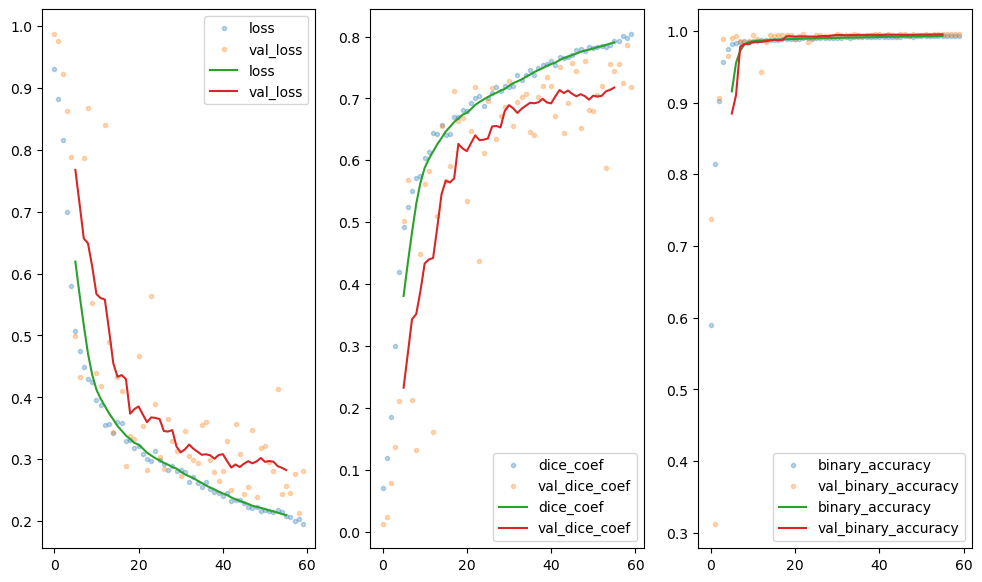

In [16]:
# Plot initial results
fig, axes = plt.subplots(1, 3, figsize = (12, 7))
history_df[["loss","val_loss"]].plot(ax=axes[0],lw=0,marker=".",alpha=0.3)
history_df[["loss","val_loss"]].rolling(10,center=True).mean().plot(ax=axes[0])

history_df[["dice_coef","val_dice_coef"]].plot(ax=axes[1],lw=0,marker=".",alpha=0.3)
history_df[["dice_coef","val_dice_coef"]].rolling(10,center=True).mean().plot(ax=axes[1])

history_df[["binary_accuracy","val_binary_accuracy"]].plot(ax=axes[2],lw=0,marker=".",alpha=0.3)
history_df[["binary_accuracy","val_binary_accuracy"]].rolling(10,center=True).mean().plot(ax=axes[2])

Both training and validation loss seem to decrease nicely until epoch 20, when the decreasing slows down. We could try training more, but training too much might result in overfitting.

Since we have saved the model checkpoints, we can still try to cut the learning rate in half and continue for some more epochs. By reducing the learning rate, we might be able to fine-tune the model slightly more. 

In [17]:
new_lr = model.optimizer.learning_rate/2
K.set_value(model.optimizer.learning_rate, new_lr)

epochs = 20

for epoch in range(init_epoch+1,init_epoch+epochs+1):
    # Saving the best model checkpoint
    checkpoint_filepath = f"checkpoints/cp-epoch_{epoch}.ckpt"
    cp_callback = ModelCheckpoint(checkpoint_filepath, save_weights_only=True, verbose=1, save_best_only=True)
    callbacklist = [cp_callback, csv_logger]
    
    history_more = model.fit(train_generator,
                        epochs=epoch,
                        steps_per_epoch = (image_data_generator.samples // batch_size),
                        validation_data = validation_generator, 
                        validation_steps = (image_valid_data_generator.samples // batch_size),
                        initial_epoch = init_epoch,
                       workers=1,
                       callbacks=callbacklist)
    init_epoch = epoch
    if history_df.empty:
        history_df = pd.DataFrame(history_more.history)
    else:
        history_df = pd.concat([history_df,pd.DataFrame(history_more.history)],ignore_index=True)

Epoch 61/61
76/76 [==============================] - ETA: 0s - loss: 0.1873 - dice_coef: 0.8127 - binary_accuracy: 0.9933 
Epoch 61: val_loss improved from inf to 0.27032, saving model to checkpoints\cp-epoch_61.ckpt
76/76 [==============================] - 13s 169ms/step - loss: 0.1873 - dice_coef: 0.8127 - binary_accuracy: 0.9933 - val_loss: 0.2703 - val_dice_coef: 0.7297 - val_binary_accuracy: 0.9950
Epoch 62/62
76/76 [==============================] - ETA: 0s - loss: 0.1784 - dice_coef: 0.8216 - binary_accuracy: 0.9936 
Epoch 62: val_loss improved from inf to 0.28420, saving model to checkpoints\cp-epoch_62.ckpt
76/76 [==============================] - 13s 166ms/step - loss: 0.1784 - dice_coef: 0.8216 - binary_accuracy: 0.9936 - val_loss: 0.2842 - val_dice_coef: 0.7158 - val_binary_accuracy: 0.9947
Epoch 63/63
76/76 [==============================] - ETA: 0s - loss: 0.1780 - dice_coef: 0.8220 - binary_accuracy: 0.9936 
Epoch 63: val_loss improved from inf to 0.24471, saving model t

<Axes: >

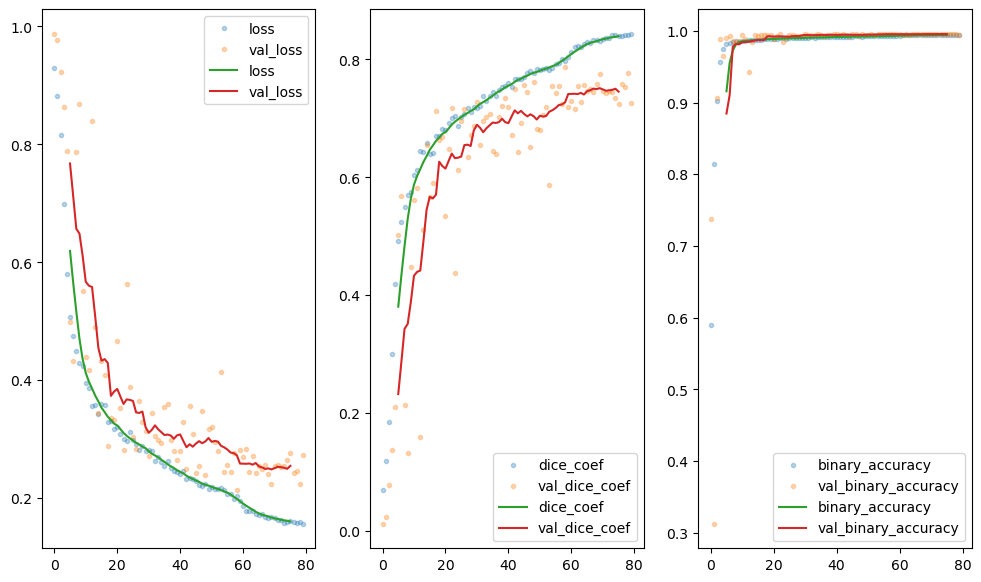

In [18]:
fig, axes = plt.subplots(1, 3, figsize = (12, 7))
history_df[["loss","val_loss"]].plot(ax=axes[0],lw=0,marker=".",alpha=0.3)
history_df[["loss","val_loss"]].rolling(10,center=True).mean().plot(ax=axes[0])

history_df[["dice_coef","val_dice_coef"]].plot(ax=axes[1],lw=0,marker=".",alpha=0.3)
history_df[["dice_coef","val_dice_coef"]].rolling(10,center=True).mean().plot(ax=axes[1])

history_df[["binary_accuracy","val_binary_accuracy"]].plot(ax=axes[2],lw=0,marker=".",alpha=0.3)
history_df[["binary_accuracy","val_binary_accuracy"]].rolling(10,center=True).mean().plot(ax=axes[2])

The loss got slightly lower, but it looks like it hit a plateau and even starts to increase closer to 80.

Let's check what is the best model (has smallest val_loss or highest val_dice_coef) and let's load its weights.

In [19]:
history_df.val_dice_coef.sort_values()

0     0.012497
1     0.023718
2     0.077936
8     0.131738
3     0.137265
        ...   
68    0.758811
48    0.761118
69    0.775843
78    0.776579
58    0.786984
Name: val_dice_coef, Length: 80, dtype: float64

In [20]:
best_model_index = history_df.val_dice_coef.sort_values().index[-1]
print(best_model_index)

58


In [21]:
cp_file_name = f"checkpoints/cp-epoch_{best_model_index}.ckpt"
model.load_weights(cp_file_name)

### Evaluation and prediction

Predicting three masks from the training set to see how it learned.

Text(0.5, 0.98, 'Train images')

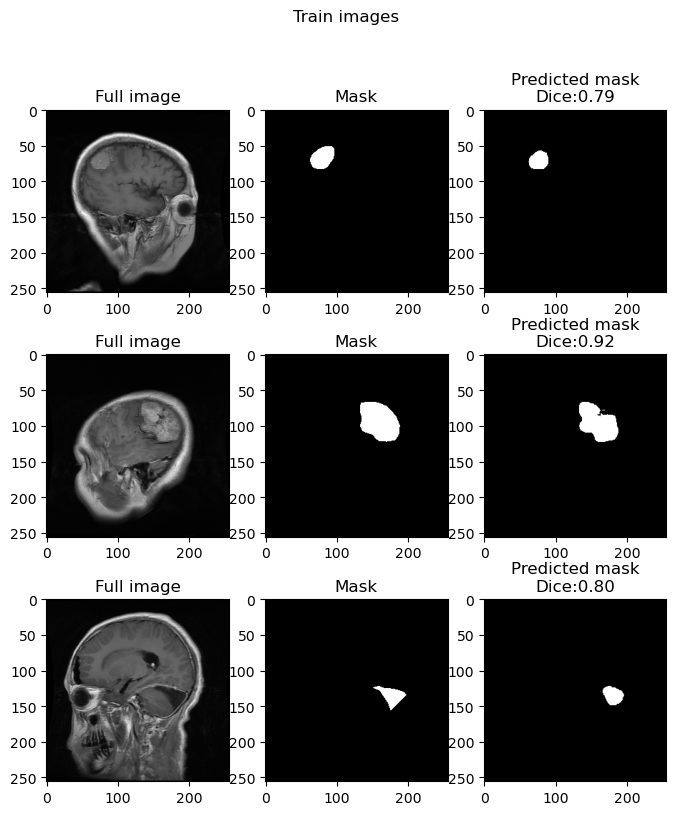

In [26]:
from tensorflow.keras.utils import load_img, img_to_array

offset = 2
images = image_data_generator.__getitem__(offset)
masks = mask_data_generator.__getitem__(offset)


fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8,9))
for i in range(3):
    img_lung = images[i,:,:,:]
    img_mask = masks[i,:,:,:]
    
    img_lung_array = img_to_array(img_lung)
    to_predict = img_lung_array.reshape((1, img_lung_array.shape[0], img_lung_array.shape[1], img_lung_array.shape[2]))
    predicted = model.predict(to_predict)
    
    img_mask_array = img_to_array(img_mask)
    to_tensor = img_mask_array.reshape((1, img_mask_array.shape[0], img_mask_array.shape[1], img_mask_array.shape[2]))
    dice = dice_coef(tf.convert_to_tensor(to_tensor), tf.convert_to_tensor(predicted[0,:,:,:]))
    
    ax[i][0].imshow(img_lung)
    ax[i][1].imshow(img_mask,cmap="gray")
    ax[i][2].imshow(predicted[0,:,:,:],cmap="gray")
    ax[i][0].set_title("Full image")
    ax[i][1].set_title("Mask")
    ax[i][2].set_title("Predicted mask\nDice:{:.2f}".format(dice))
fig.suptitle("Train images")

Based on these three images, it learned the mask area quite well, although the shapes are not exactly the same.

Text(0.5, 0.98, 'Valid images')

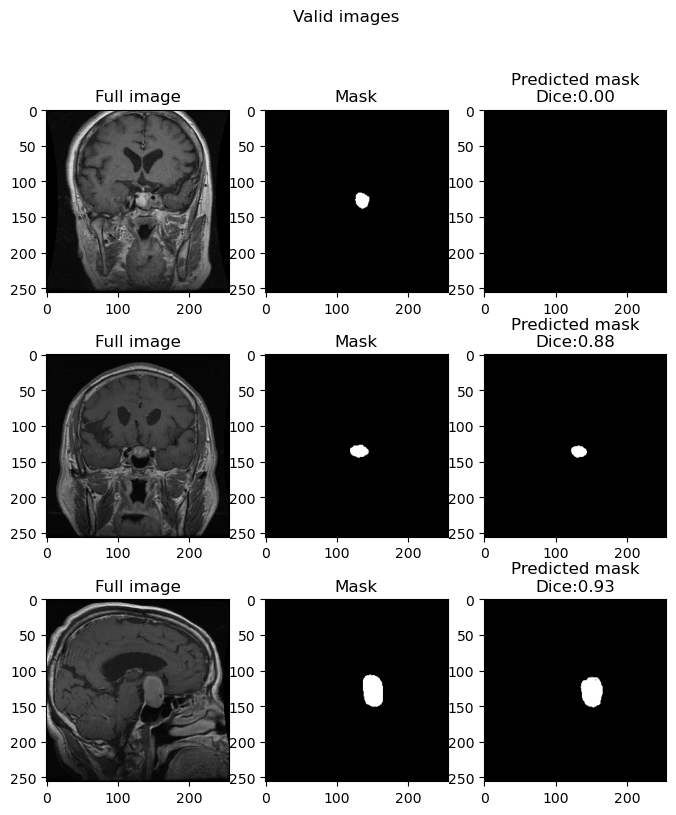

In [29]:
# Predicting three masks from the validation set.

offset = 1
images = image_valid_data_generator.__getitem__(offset)
masks = mask_valid_data_generator.__getitem__(offset)


fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8,9))
for i in range(3):
    img_lung = images[i,:,:,:]
    img_mask = masks[i,:,:,:]
    
    img_lung_array = img_to_array(img_lung)
    to_predict = img_lung_array.reshape((1, img_lung_array.shape[0], img_lung_array.shape[1], img_lung_array.shape[2]))
    predicted = model.predict(to_predict)
    
    img_mask_array = img_to_array(img_mask)
    to_tensor = img_mask_array.reshape((1, img_mask_array.shape[0], img_mask_array.shape[1], img_mask_array.shape[2]))
    dice = dice_coef(tf.convert_to_tensor(to_tensor), tf.convert_to_tensor(predicted[0,:,:,:]))
    
    ax[i][0].imshow(img_lung)
    ax[i][1].imshow(img_mask,cmap="gray")
    ax[i][2].imshow(predicted[0,:,:,:],cmap="gray")
    ax[i][0].set_title("Full image")
    ax[i][1].set_title("Mask")
    ax[i][2].set_title("Predicted mask\nDice:{:.2f}".format(dice))
fig.suptitle("Valid images")

The model performs well on the validation set (which the model wasn't trained on) except in the first image where it doesn't detect anything.

The model could be improved by:
- Finding better parameters for the u-net model and training
- Using full image size
- Training more with things like learning rate scheduler that automatically reduces the learning rate during training.
- Using more data

However, for a smallish dataset of 3000 photos, photo sizes of 256x256 and just 20 minutes of training, I think the model performs surprisingly well.

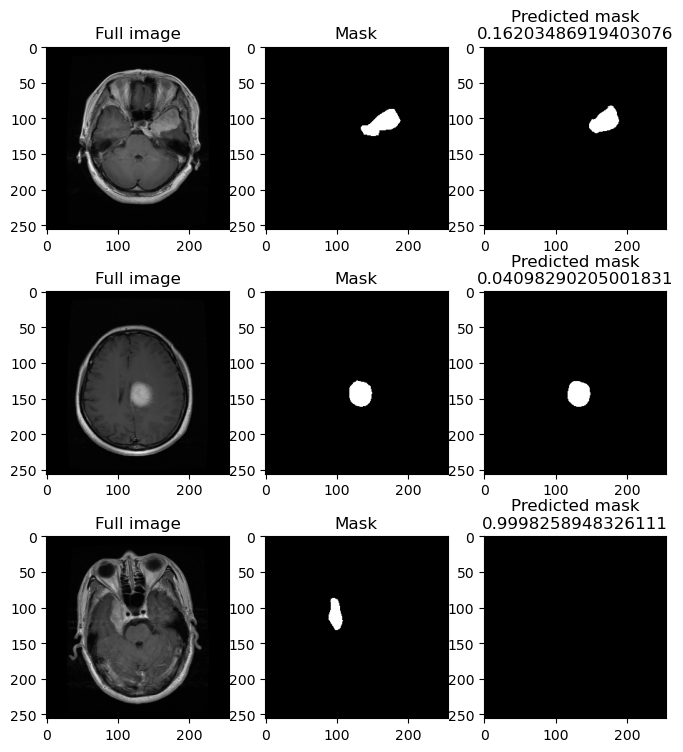

In [30]:
# Old test cell for manual importing of test photos

from tensorflow.keras.utils import load_img, img_to_array

test_offset = 0

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8,9))
for i in range(3):
    img_lung = load_img(os.path.join(PATH_image,os.listdir(PATH_image)[i+test_offset]),color_mode="rgb",target_size=(image_size,image_size))
    img_mask = load_img(os.path.join(PATH_mask,os.listdir(PATH_mask)[i+test_offset]),color_mode="grayscale",target_size=(image_size,image_size))
    
    img_lung_array = img_to_array(img_lung)/255
    to_predict = img_lung_array.reshape((1, img_lung_array.shape[0], img_lung_array.shape[1], img_lung_array.shape[2]))
    predicted = model.predict(to_predict)
    
    img_mask_array = img_to_array(img_mask)/255
    to_tensor = img_mask_array.reshape((1, img_mask_array.shape[0], img_mask_array.shape[1], img_mask_array.shape[2]))
    dice = dice_coef_loss(tf.convert_to_tensor(to_tensor), tf.convert_to_tensor(predicted[0,:,:,:]))
    
    ax[i][0].imshow(img_lung)
    ax[i][1].imshow(img_mask,cmap="gray")
    ax[i][2].imshow(predicted[0,:,:,:],cmap="gray")
    ax[i][0].set_title("Full image")
    ax[i][1].set_title("Mask")
    ax[i][2].set_title(f"Predicted mask\n{dice}")